# Wind Turbine Power Generation Forecasting

Train dataset contains hourly meteorological data along with power output measurements collected between January 2013 and December 2016. The data includes variables such as temperature, relative humidity, wind speed at various altitudes, and power generated at different locations.

1. Import dependencies.

In [1]:
from lib.ml.layer.layer_def import Dense, Input
from lib.ml.util.loss_function import MEAN_SQUARED_ERROR
from lib.ml.model.seq_model import SeqNet
from lib.ml.optimizer.genetic_optimizer import GeneticAlgorithmNeuralNetOptimizer
from lib.ml.util.progress_tracker import NotebookProgressTracker
from src.data.wind_turbine.wind_turbine_dataset import (
    download_wind_turbine_dataset,
    process_wind_turbine_dataset,
)
from src.definitions import EXTERNAL_DATA_FOLDER
from src.definitions import TEST_TRAIN_RATIO
from src.visualization.plot import plot_loss, plot_diff

2. Download and process `sudhanvahg/wind-turbine-power-generation-forecasting` dataset.

In [2]:
archive = download_wind_turbine_dataset(EXTERNAL_DATA_FOLDER)
train, test = process_wind_turbine_dataset(archive, TEST_TRAIN_RATIO)

train.head(5)

,Location,Temp_2m,RelHum_2m,DP_2m,WS_10m,WS_100m,WD_10m,WD_100m,WG_10m,Power
0,1,28.2796,84.664205,24.072595,1.605389,1.267799,145.051683,161.057315,1.336515,0.163496
1,1,28.1796,85.664205,24.272595,2.225389,3.997799,150.051683,157.057315,4.336515,0.142396
2,1,26.5796,90.664205,24.072595,1.465389,2.787799,147.051683,149.057315,3.136515,0.121396
3,1,27.1796,87.664205,23.872595,1.465389,2.697799,57.051683,104.057315,1.536515,0.100296
4,1,27.0796,87.664205,23.672595,2.635389,4.437799,57.051683,83.057315,3.936515,0.079296


3. Define neural network.

In [3]:
model = SeqNet(layers=[Input(9), Dense(18), Dense(1)])
opt = GeneticAlgorithmNeuralNetOptimizer(
    population_size=200, mutation_rate=0.5, mutation_decay=0.005
)

compiled_model = model.compile(
    optimizer=opt,
    loss=MEAN_SQUARED_ERROR,
    progress_tracker=NotebookProgressTracker(),
)

4. Train neural network.

In [4]:
from sklearn.discriminant_analysis import StandardScaler


train_x = train.iloc[:, :-1].to_numpy()
train_y = train.iloc[:, -1].to_numpy().reshape(1, -1)

scaler = StandardScaler()
train_x_scaled = scaler.fit_transform(train_x)

trained_model = compiled_model.fit(train_x_scaled.T, train_y, 300, 10_000)

print("Train accuracy = " + str(trained_model.metrics().accuracy))

Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Train accuracy = 0.04318503388689419


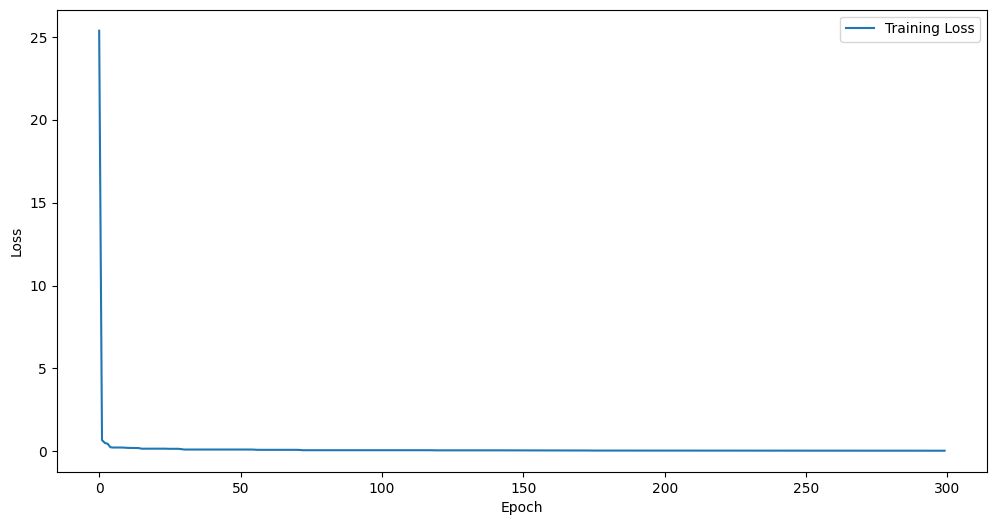

In [5]:
plot_loss(trained_model)

5. Test neural network.

In [6]:
test_x = test.iloc[:, :-1].to_numpy()
test_y = test.iloc[:, -1].to_numpy().reshape(1, -1)

test_x_scaled = scaler.transform(test_x)

y_predicted = trained_model.predict(test_x.T)

print("Test accuracy = " + str(MEAN_SQUARED_ERROR.apply(test_y, y_predicted)))

Test accuracy = 4.902076968102575


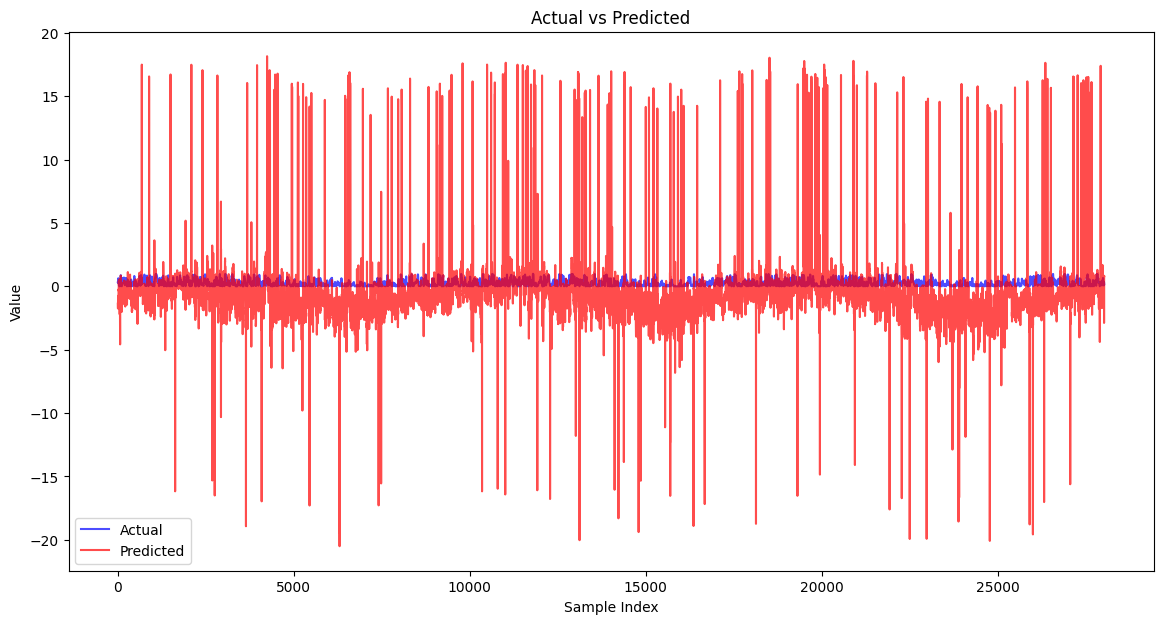

In [7]:
plot_diff(test_y.flatten(), y_predicted.flatten())